In [1]:
import fluids
import gradient_calc as gc
import gradient_functions as gf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import scipy.constants as SPC

In [2]:
df = pd.read_clipboard()
df.columns

Index(['vlp.solver_kwargs['method']', '=', ''BDF''], dtype='object')

In [3]:
D = 1.995 * SPC.inch
x = [-1015, 0]
eps = 0.045e-3
tubing = gc.Tubing(D=D,eps=eps,x_points=x, k=1)
print('Area:', tubing.get_area())
tubing.get_inclination(-10)


Area: 0.0020167084344950184


array(1.)

In [4]:
T = SPC.convert_temperature(25, 'C', 'K')
print(T)
gas = fluids.Gas(composition={'C1': 1}, ref_T=T)
water = fluids.Water(salinity=90, ref_T=T)
print(gas.get_standard_density(), water.get_density(SPC.atm))

298.15
0.6784908149356519 1054.6881293842014


In [5]:
vlp = gc.BiPhaseVLP(tubing, liquid=water, gas=gas, T=T, sigma_function = lambda P, T: 30,
                    payne_correction=False, holdup_adj=1)
vlp.solver_kwargs['method'] = 'BDF'

In [11]:
print(100000 / SPC.day * gas.get_standard_density())
100000 / SPC.day / tubing.get_area()


0.785290295064412


573.9091420506808

In [17]:
gas.get_compressibility(4e5)

2.5158388512547677e-06

In [36]:
WGR = 1e-3
qvalues = np.logspace(3, np.log10(40000), 10)
THPref = 10 * SPC.bar
BHPref = 50 * SPC.bar

qgvalues_mass = qvalues / SPC.day * gas.get_standard_density()
vlp.verbose=False
out = {'BHP': dict(), 'THP': dict()}
for WGR in (0.01e-3, 0.1e-3, 0.5e-3, 1e-3):
    qwvalues_mass = qvalues / SPC.day * WGR * water.get_density(SPC.atm)
    BHPv = list()
    THPv = list()
    for qw, qg in zip(qwvalues_mass, qgvalues_mass):
        try:
            bhp = vlp.get_end_pressure([qw, qg], THP=THPref)
            #print(BHP)
            BHPv.append(bhp)
            thp = vlp.get_end_pressure([qw, qg], BHP=BHPref)
            THPv.append(thp)
        except:
            vlp.verbose=True
            thp = vlp.get_end_pressure([qw, qg], BHP=BHPref)
            raise
        finally:
            vlp.verbose=False
    print(thp/SPC.bar)
    out['BHP'][WGR] = np.array(BHPv) / SPC.bar
    out['THP'][WGR] = np.array(THPv) / SPC.bar

40.15236063864238
35.209197977719974
26.791116652706034
15.408392981490428


Text(0, 0.5, 'THP [bar]')

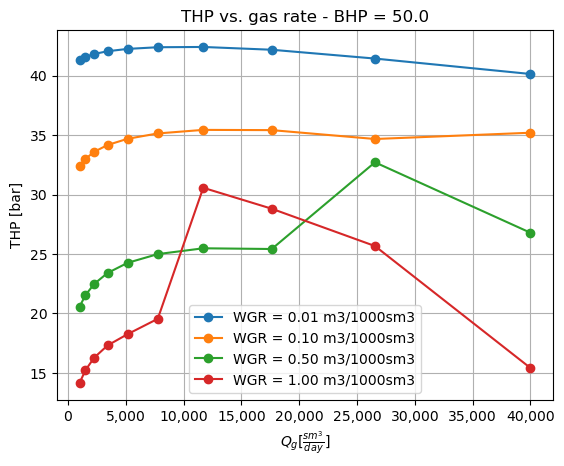

In [37]:
fig, ax = plt.subplots()
key = 'THP'
for WGR, val in out[key].items():
    ax.plot(qvalues, val, marker='o', label='WGR = {:.2f} m3/1000sm3'.format(WGR * 1000))

ax.set_title(f'{key} vs. gas rate - ' + '{} = {:.1f}'.format(*(('BHP', BHPref/1e5) if key == 'THP' else ('THP', THPref/1e5))))
ax.legend(loc='best')
ax.grid()
ax.xaxis.set_major_formatter(tkr.FuncFormatter('{:,.0f}'.format))
ax.set_xlabel('$Q_g [\\frac{sm^3}{day}]$')
ax.set_ylabel(f'{key} [bar]')